# Lab 4 - Stochastic Gradient Descent and Regularization
1. Use the code for MNIST Images using CNNs that you wrote for Lab 2 and performs the following tasks Use Gradient Descent and Stochastic Gradient Descent (SGD) as the learning algorithms and compare the performance for 100 epochs of training. Plot the Loss vs Epochs on the same graph
2. Using SGD for the same example do the following and comapre the results for each case with the base case done in using SGD in part 1
    1.   Train your network using SGD with momentum = 0.9
    2.   Train your network using SGD with Dropout
    3.   Train your network using SGD with L2 regularization 

You should be able to compare the training and test performance for all the three cases with the base case.

### and also note that we used Adam as the optmizer istead of SGD optmizer because Adam is a combination of SGD and other newer optimizer so it is even better! 

In [1]:
# import packages from previous labs
import torch
import torch.nn.functional as F
from torch import autograd, nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import pandas as pd
import torch.nn as nn
import torch.utils.data.dataloader as dataloader
import torch.optim as optim
from torch import autograd, nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, SubsetRandomSampler 
from torchvision import transforms, datasets
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
%matplotlib inline
import time

# 1. Set up and load data

In [2]:
num_epochs = 100
num_classes = 10
sample_size=100 
batch_size = sample_size
learning_rate = 0.01 

# This code was copied from the previous lab 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import time

train = MNIST('./data', train=True, download=True, transform=transforms.ToTensor())

test = MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

cuda = torch.cuda.is_available()

#set the arguments
dataloader_args = dict(shuffle=False, batch_size=batch_size,num_workers=4, pin_memory=True) if cuda \
                        else dict(shuffle=False, batch_size=batch_size)
train_loader = dataloader.DataLoader(train, **dataloader_args,sampler= SubsetRandomSampler(np.random.RandomState(seed=0).randint(0,len(train)-1,sample_size).tolist())) 
test_loader = dataloader.DataLoader(test, **dataloader_args)

# Define model without Dropout

In [3]:
class ConvNetWOD(nn.Module):
        def __init__(self):
            super(ConvNetWOD, self).__init__() 
            self.layer1 = nn.Sequential(    
                nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2), 
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))
            self.layer2 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))
            #self.drop_out = nn.Dropout() #a drop-out layer to avoid over-fitting
        
            self.fc1 = nn.Linear(7 * 7 * 64, 1000) 
            self.fc2 = nn.Linear(1000, 10)

        def forward(self, x):
            out = self.layer1(x)
            out = self.layer2(out)
            out = out.reshape(out.size(0), -1)
            #out = self.drop_out(out)
            out = self.fc1(out)
            out = self.fc2(out)
            return out
        
        def backward(self, delta):
            n = len(self.__layers)

            for i in self.__layers[::-1]:
                delta = self.__layers[i].backward(delta)

            return

# Define model with dropout (uncomment that line with dropout layer)


In [4]:
class ConvNetWD(nn.Module):
        def __init__(self):
            super(ConvNetWD, self).__init__() 
            self.layer1 = nn.Sequential(    
                nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2), 
                nn.ReLU(), 
                nn.MaxPool2d(kernel_size=2, stride=2))
            self.layer2 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)  )
            self.drop_out = nn.Dropout() #uncommented
            
            self.fc1 = nn.Linear(7 * 7 * 64, 1000) 
            self.fc2 = nn.Linear(1000, 10)

        def forward(self, x):
            out = self.layer1(x)
            out = self.layer2(out)
            out = out.reshape(out.size(0), -1)
            out = self.drop_out(out)
            out = self.fc1(out)
            out = self.fc2(out)
            return out
        
        def backward(self, delta):
            n = len(self.__layers)

            for i in self.__layers[::-1]:
                delta = self.__layers[i].backward(delta)

            return

# Gradient Descent without Dropout layer

In [5]:
model0 = ConvNetWOD()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model0.parameters(), lr=learning_rate)
    
#the training loop
total_step = len(train_loader)
loss_listGDWOD = []
acc_listGDWOD = []
for epoch in range(num_epochs): 
    for i, (images, labels) in enumerate(train_loader): 
        outputs = model0(images) 
        loss = criterion(outputs, labels)
        optimizer.zero_grad()  #make the initial gradients zero
        loss.backward()  #perform the back-propagation
        optimizer.step() #step() method updates the parameters

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1) 
        correct = (predicted == labels).sum().item()

    acc_listGDWOD.append(correct / total)
    loss_listGDWOD.append(loss.item())

# Stochastic GD without Dropout

In [6]:
# new params for SGD
num_epochs = 100
num_classes = 10
sample_size=100  
batch_size = 1  
learning_rate = 0.01 

#set the arguments
dataloader_args = dict(shuffle=False, batch_size=batch_size,num_workers=4, pin_memory=True) if cuda \
                        else dict(shuffle=False, batch_size=batch_size)

train_loader = dataloader.DataLoader(train, **dataloader_args,sampler= SubsetRandomSampler(np.random.RandomState(seed=0).randint(0,len(train)-1,sample_size).tolist())) 
test_loader = dataloader.DataLoader(test, **dataloader_args)

model0 = ConvNetWOD()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model0.parameters(), lr=learning_rate)

total_step = len(train_loader)
loss_listSGDWOD = []
acc_listSGDWOD = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): 
        # Run the forward pass
        outputs = model0(images) 
        loss = criterion(outputs, labels)
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step() 

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1) 
        correct = (predicted == labels).sum().item()
        
    acc_listSGDWOD.append(correct / total)
    loss_listSGDWOD.append(loss.item())

# Plot SGD vs GD without dropout

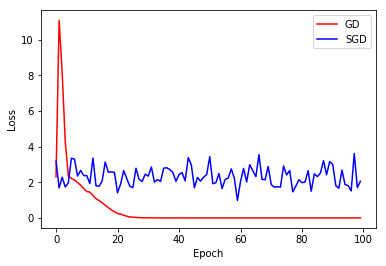

In [20]:
plt.plot(loss_listGDWOD,'red',label='GD')
plt.plot(loss_listSGDWOD,'blue',label='SGD')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

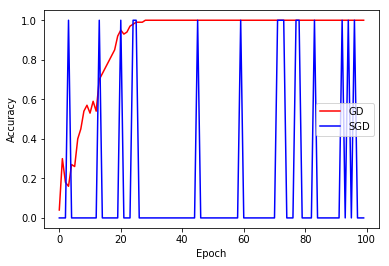

In [19]:
plt.plot(acc_listGDWOD,'red',label='GD')
plt.plot(acc_listSGDWOD,'blue',label='SGD')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 2.1 SGD with momentum = 0.9

In [9]:
model0 = ConvNetWOD()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model0.parameters(), lr=learning_rate,momentum = 0.9 ) 

total_step = len(train_loader)
loss_listMomentum = []
acc_listMomentum = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model0(images) 
        loss = criterion(outputs, labels)
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step() 

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1) 
        correct = (predicted == labels).sum().item()
    acc_listMomentum.append(correct / total)
    loss_listMomentum.append(loss.item())

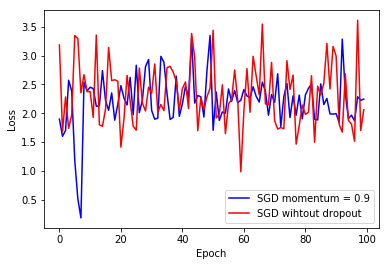

In [18]:
plt.plot(loss_listMomentum,'blue',label='SGD momentum = 0.9')
plt.plot(loss_listSGDWOD,'red',label='SGD wihtout dropout')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

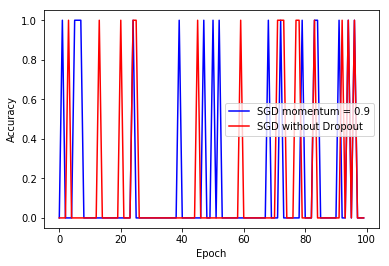

In [17]:
plt.plot(acc_listMomentum,'blue',label='SGD momentum = 0.9')
plt.plot(acc_listSGDWOD,'red',label='SGD without Dropout')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 2.2 SGD with Dropout

In [13]:
model0 = ConvNetWD()
# With Dropout

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model0.parameters(), lr=learning_rate)
    
total_step = len(train_loader)
loss_listSGDWD = []
acc_listSGDWD = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model0(images) 
        loss = criterion(outputs, labels)
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1) 
        correct = (predicted == labels).sum().item()
    acc_listSGDWD.append(correct / total)
    loss_listSGDWD.append(loss.item())

### Plot Stochastic Gradient Descent with dropout and SGD without dropout (base)

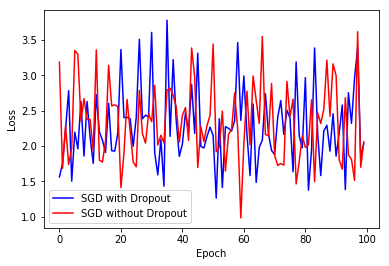

In [14]:
plt.plot(loss_listSGDWD,'blue',label='SGD with Dropout')
plt.plot(loss_listSGDWOD,'red',label='SGD without Dropout')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

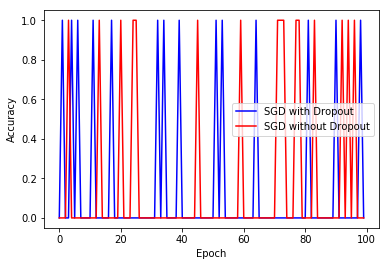

In [15]:
plt.plot(acc_listSGDWD,'blue',label='SGD with Dropout')
plt.plot(acc_listSGDWOD,'red',label='SGD without Dropout')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 2.3 SGD with L2 regularization

In [21]:
model0 = ConvNetWOD() 
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model0.parameters(), lr=learning_rate,weight_decay=0.001 ) 

total_step = len(train_loader)
loss_listL2 = []
acc_listL2 = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): 
        outputs = model0(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()  
        optimizer.step() 

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1) 
   
        correct = (predicted == labels).sum().item()

    acc_listL2.append(correct / total)
    loss_listL2.append(loss.item())

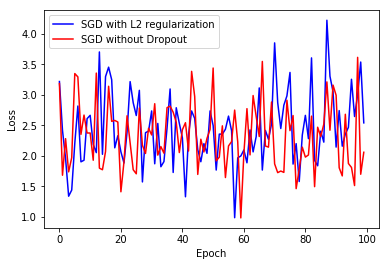

In [22]:
plt.plot(loss_listL2,'blue',label='SGD with L2 regularization')
plt.plot(loss_listSGDWOD,'red',label='SGD without Dropout')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

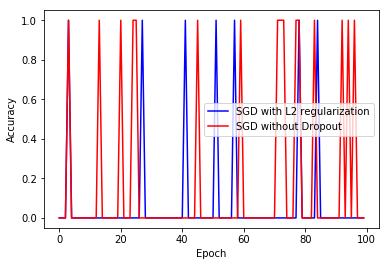

In [23]:
plt.plot(acc_listL2,'blue',label='SGD with L2 regularization')
plt.plot(acc_listSGDWOD,'red',label='SGD without Dropout')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()